In [15]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as stattools
import statsmodels.tsa.ardl as ardl
import math
import pmdarima as pm

import lead_lag as ll
from datetime import datetime, timedelta

In [16]:
df = pd.read_csv("../prices.txt", sep='\s+', header=None, index_col=None)
df = df.iloc[:750, :]
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,750.000000,750.000000,750.000000,750.00000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,...,750.000000,750.000000,750.00000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,13.078840,67.138093,46.807147,46.95556,54.643760,10.681347,18.109813,48.211907,68.473213,52.620227,...,31.064200,68.784853,11.81856,60.377627,35.325480,51.670480,63.454093,34.518627,39.668173,55.348173
std,1.378103,4.302388,0.832783,2.28231,1.933828,1.616296,0.369141,2.652764,0.567559,4.485318,...,1.153013,10.242647,1.25213,2.223501,2.226551,1.306506,9.641447,0.865177,3.939906,1.566283
min,10.130000,60.050000,45.440000,43.12000,51.150000,7.710000,17.170000,44.010000,67.260000,45.260000,...,28.650000,50.620000,9.61000,52.990000,29.450000,48.400000,49.200000,32.800000,31.640000,51.760000
25%,12.405000,63.560000,46.032500,45.31000,53.055000,8.720000,17.880000,46.320000,68.050000,48.572500,...,30.530000,57.150000,10.67000,59.040000,33.207500,50.382500,54.752500,33.870000,36.560000,54.202500
50%,13.260000,66.275000,46.820000,45.82000,54.340000,11.480000,18.090000,47.495000,68.475000,52.205000,...,31.045000,70.355000,11.81500,60.560000,35.835000,52.050000,61.860000,34.490000,39.600000,55.455000
75%,14.105000,71.607500,47.307500,48.76750,56.267500,12.040000,18.420000,49.340000,68.850000,56.635000,...,32.037500,77.832500,12.38000,61.860000,37.205000,52.640000,71.357500,35.090000,42.427500,56.555000
max,15.560000,75.150000,48.610000,51.01000,59.120000,13.000000,18.980000,55.930000,69.990000,62.650000,...,33.260000,84.810000,14.50000,66.090000,39.130000,54.150000,83.060000,36.480000,50.020000,59.310000


<Axes: ylabel='0'>

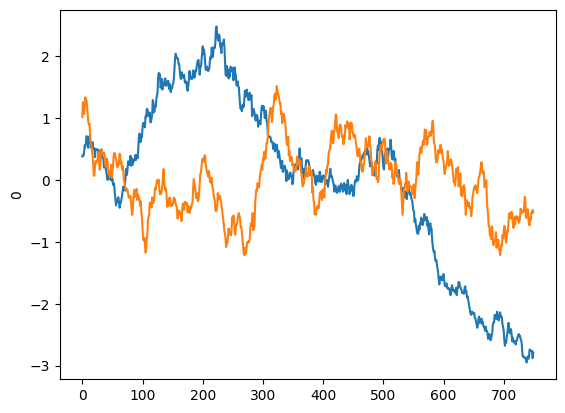

In [25]:
sns.lineplot(df[0] - df[0].mean())
sns.lineplot(df[8] - df[8].mean())

In [26]:
memo = {}
for ticker in range(50):
    if ticker in [2, 6, 16, 27, 38, 39]:
        continue

    result = ardl.ARDL(
            df[ticker].pct_change().dropna().values[:],
            0,
            df[list(range(50))].pct_change().dropna().values[:],
            np.array([1, 286, 287, 288]),
            causal=True
        ).fit()
    memo[ticker] = result.params[1:]
memo

{0: array([ 6.93377357e-02,  6.37163507e-04,  4.85710498e-02, -6.47709682e-03,
         9.78034852e-02, -1.01734885e-03,  3.29110049e-01,  1.13075132e-03,
        -4.03115053e-02,  1.79436407e-02, -7.12187413e-01,  4.58188225e-02,
         1.45155141e-01,  1.18036272e-02, -1.22697856e-01,  4.21323099e-03,
         2.97920742e-01, -6.19122317e-03,  2.18669901e-01, -5.71691955e-03,
        -4.79975056e-02,  8.00708249e-03, -2.25518961e-01, -6.05309611e-03,
         1.13441019e-01, -2.00914803e-02,  2.54793115e-02, -9.59350375e-03,
         4.93325329e-02, -4.48083893e-04, -3.15179346e-02, -6.03640223e-03,
        -9.01590154e-01,  1.95006435e-03, -2.43974989e-01,  6.20542019e-03,
         1.33426105e-02,  1.33566939e-03,  2.51561448e-02,  2.02455133e-03,
         8.24565707e-03,  1.47904961e-03,  2.15356551e-01, -3.57276762e-03,
        -1.22051175e-01, -1.29261287e-03,  6.10645020e-03, -1.51080811e-02,
        -3.37136029e-01,  2.09913131e-04, -3.24890063e-01, -2.08162094e-03,
        -

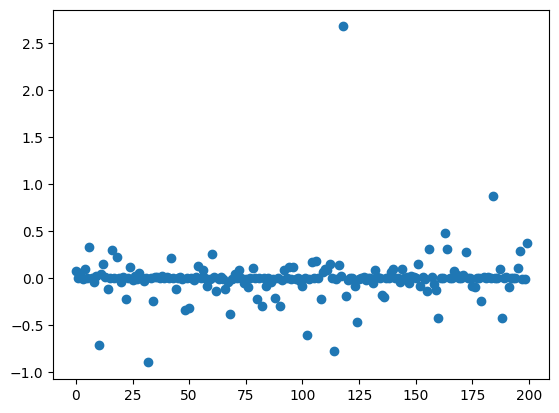

In [27]:
plt.scatter(list(range(len(memo[0]))), memo[0])

In [28]:
# Parse the params
parsedMemo = {}
lags = [1, 286, 287, 288]
others = list(range(50))

for ticker in memo:
    params = memo[ticker]
    start = 0
    paramWeight = []
    for other in others:
        currentParam = params[start:start + 4]
        start = start + 4
        for i in range(4):
            if abs(currentParam[i]) > 1e-02:
                paramWeight.append((other, lags[i], currentParam[i]))
    paramWeight.sort(key=lambda x: -abs(x[2]))
    parsedMemo[ticker] = paramWeight[:4]

parsedMemo 

        

        
    

{0: [(29, 287, 2.680133184242259),
  (8, 1, -0.9015901543340705),
  (46, 1, 0.876504277135875),
  (28, 287, -0.7827839197740505)],
 1: [(30, 287, 0.7383373268660848),
  (39, 288, -0.37446230524753493),
  (2, 287, 0.30697998612277333),
  (2, 1, -0.2558536086135148)],
 3: [(32, 287, 0.3197316475483351),
  (40, 288, 0.1038067125214508),
  (1, 287, -0.10089568161625145),
  (47, 1, -0.07257407045478767)],
 4: [(33, 287, 0.5838242419301543),
  (8, 287, 0.13049686556058981),
  (39, 288, -0.12905335181390865),
  (49, 288, -0.10836198594076936)],
 5: [(34, 287, 1.5968549182726492),
  (24, 287, -0.6620477921665922),
  (45, 1, 0.6544957431112811),
  (16, 287, -0.611859629168769)],
 7: [(36, 287, 0.9907700648517112),
  (4, 1, 0.1978444576682965),
  (2, 1, -0.19298623861739256),
  (46, 1, 0.1779661460740505)],
 8: [(37, 287, 0.17345061591784913),
  (39, 1, 0.12456169711574279),
  (2, 287, -0.11091809492905891),
  (22, 287, -0.10062233357259365)],
 9: [(38, 287, 16.098682389022382),
  (22, 287, -5.1